In [ ]:
from models import Autoencoder #toTensor, var_to_np, Autoencoder 
import cv2
import argparse
import torch
import os
import dlib
from tqdm import tqdm

#from models import , 
from image_augmentation import random_warp
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
import torchvision
%matplotlib inline

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

In [ ]:
def toTensor(img):
    img = torch.from_numpy(img.transpose((0, 3, 1, 2)))
    return img

def var_to_np(img_var):
    return img_var.data.cpu().numpy()

In [3]:
def get_face(img):
    detector = dlib.get_frontal_face_detector()
    dets = detector(img, 1)
    if dets:
        left = dets[0].left()
        top = dets[0].top()
        right = dets[0].right()
        bot = dets[0].bottom()

        return True, img[top:bot, left:right]
    return False, None

def extract_face(frame):
    detector = dlib.get_frontal_face_detector()
    img = frame
    dets = detector(img, 1)
    for idx, face in enumerate(dets):
        position = {}
        position['left'] = face.left()
        position['top'] = face.top()
        position['right'] = face.right()
        position['bot'] = face.bottom()
        croped_face = img[position['top']:position['bot'], position['left']:position['right']]

        return position, croped_face


def extract_faces(video_path):
    cap = cv2.VideoCapture(video_path)
    n = 0
    while (cap.isOpened() and n<1000):
        _, frame = cap.read()
        position, cropped_face= extract_face(frame)
        #print(croped_face.shape)
        #exit(0)
        #cv2.imshow("croped_face",croped_face)
        #cv2.waitKey(2000)
        #cv2.destroyAllWindows()
        converted_face = convert_face(cropped_face)
        converted_face = converted_face.squeeze(0)
        converted_face = var_to_np(converted_face)
        converted_face = converted_face.transpose(1,2,0)
        converted_face = np.clip(converted_face * 255, 0, 255).astype('uint8')
        cv2.imshow("converted_face", cv2.resize(converted_face, (256,256)))
        cv2.waitKey(2000)
        back_size = cv2.resize(converted_face, (cropped_face.shape[0]-15, croped_face.shape[1]-15))
        #cv2.imshow("back_face", back_size)
        #cv2.waitKey(1000)
        #print(frame.shape)
        #print(back_size.shape)
        merged = merge(position, back_size, frame)
        #print(merged.shape)
        out.write(merged)
        # cv2.imshow('frame', frame)
        # if cv2.waitKey(1) & 0xFF == ord('q'):
        #     break
        n = n + 1
        print(n)

def convert_face(cropped_face):
    resized_face = cv2.resize(cropped_face, (256, 256))
    normalized_face = resized_face / 255.0
    #normalized_face = normalized_face.reshape(1, normalized_face.shape[0], normalized_face.shape[1], normalized_face.shape[2])
    warped_img, _ = random_warp(normalized_face)
    batch_warped_img = np.expand_dims(warped_img, axis=0)

    batch_warped_img = toTensor(batch_warped_img)
    batch_warped_img = batch_warped_img.to(device).float()
    #print(batch_warped_img.shape, batch_warped_img)
    model = Autoencoder().to(device)
    checkpoint = torch.load('./checkpoint/autoencoder.t7')
    model.load_state_dict(checkpoint['state'])

    converted_face = model(batch_warped_img,'B')
    return converted_face

def merge(postion, face, body):
    #im = cv2.imread("train/images/wood-texture.jpg")
    #obj = cv2.imread("train/images/iloveyouticket.jpg")
    #print(body.shape)
    mask = 255 * np.ones(face.shape, face.dtype)
    width, height, channels = body.shape
    center = (postion['left']+(postion['right']-postion['left'])//2, postion['top']+(postion['bot']-postion['top'])//2)
    normal_clone = cv2.seamlessClone(face, body, mask, center, cv2.NORMAL_CLONE)
    return normal_clone

# def InitwriteVideo():
#     fourcc = cv2.VideoWriter_fourcc()
#     frame_width = int(cap.get(3))
#     frame_height = int(cap.get(4))

def process_video(path_in, path_out, st_frame, num_frames):
    fourcc = cv2.VideoWriter_fourcc('M', 'J', 'P', 'G')
    cap_in = cv2.VideoCapture(path_in)
    cap_out = cv2.VideoWriter(path_out, fourcc, 20, (512, 288))#
    
    cap_in.set(cv2.CAP_PROP_POS_FRAMES, st_frame)
    n = 0
    while cap_in.isOpened() and n < num_frames:
        print(n)
        _, frame = cap_in.read()
#         position, croped_face= get_face(frame)
        position, cropped_face = extract_face(frame)
        #print(position)
        
        #print(croped_face.shape)
        #exit(0)
        #cv2.imshow("croped_face",croped_face)
        #cv2.waitKey(2000)
        #cv2.destroyAllWindows()
        converted_face = convert_face(cropped_face)
        converted_face = converted_face.squeeze(0).detach().cpu().numpy()
        converted_face = converted_face.transpose(1,2,0)
        converted_face = np.clip(converted_face * 255, 0, 255).astype('uint8')
#         cv2.imshow("converted_face", cv2.resize(converted_face, (256,256)))
#         cv2.waitKey(2000)
        back_size = cv2.resize(converted_face, (cropped_face.shape[0]-15, cropped_face.shape[1]-15))#
        #cv2.imshow("back_face", back_size)
        #cv2.waitKey(1000)
        #print(frame.shape)
        #print(back_size.shape)
        merged = merge(position, back_size, frame)
        #print(merged.shape)
        cap_out.write(merged)
        n += 1
    cap_out.release()

In [27]:
path_in, path_out, st_frame, num_frames = 'video/putin_720_2018.mp4', 'video/processed5.mp4', 2000, 500

## low putin

In [39]:
cap = cv2.VideoCapture('video/putin_720_2019.mp4')
fps = cap.get(cv2.CAP_PROP_FPS)
print('fps:', fps)  # float
fps = cap.get(cv2.CAP_PROP_FRAME_COUNT)
print('frames count:', fps)  # float


fourcc = cv2.VideoWriter_fourcc(*"MJPG")
out = cv2.VideoWriter('video/low_putin_2019.mp4',fourcc, 25, (512,288))
 
while(cap.isOpened()):
    ret, frame = cap.read()
    if ret==True:
        b = cv2.resize(frame,(512,288))
        out.write(b)
    else:
        break
    
cap.release()
out.release()

fps: 25.0
frames count: 13602.0


In [28]:
fourcc = cv2.VideoWriter_fourcc('M', 'J', 'P', 'G')
cap_in = cv2.VideoCapture(path_in)

cap_in.set(cv2.CAP_PROP_POS_FRAMES, st_frame)
n = 0

In [29]:
_, frame = cap_in.read()

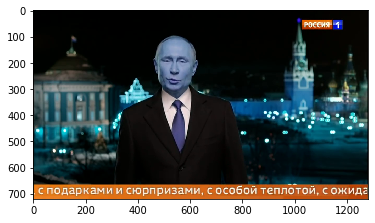

In [30]:
plt.imshow(frame)

In [31]:
position, croped_face= extract_face(frame)
croped_face.shape

(155, 155, 3)

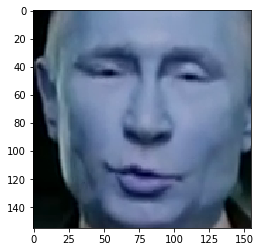

In [32]:
plt.imshow(croped_face)

In [33]:
converted_face = convert_face(croped_face)
converted_face.shape

torch.Size([1, 3, 64, 64])

In [34]:
converted_face = converted_face.squeeze(0).detach().cpu()
converted_face.shape

torch.Size([3, 64, 64])

In [35]:
converted_face = converted_face.numpy().transpose(1,2,0)
converted_face.shape

(64, 64, 3)

In [36]:
#cv2.imshow("converted_face",converted_face)
#cv2.waitKey(5000)
#cv2.destroyAllWindows()

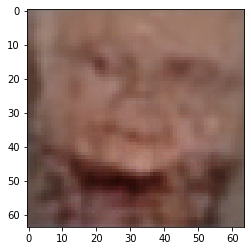

In [37]:
plt.imshow(converted_face)

In [38]:
converted_face = np.clip(converted_face * 255, 0, 255).astype('uint8')
converted_face.shape

(64, 64, 3)

In [39]:
#cv2.imshow("converted_face",converted_face)
#cv2.waitKey(2000)
#cv2.destroyAllWindows()

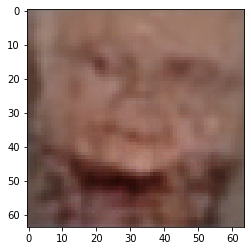

In [40]:
plt.imshow(converted_face)

In [66]:
back_size = cv2.resize(converted_face, (croped_face.shape[0]-20, croped_face.shape[1]-20))#-120
back_size.shape

(135, 135, 3)

In [67]:
merged = merge(position, back_size, frame)

In [68]:
#cv2.imshow("merged",merged)
#cv2.waitKey(2000)
#cv2.destroyAllWindows()

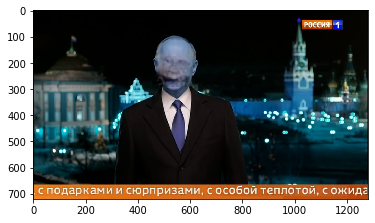

In [69]:
plt.imshow(merged)

In [22]:
model = Autoencoder().to(device)
checkpoint = torch.load('./checkpoint/autoencoder.t7')
model.load_state_dict(checkpoint['state'])

<All keys matched successfully>

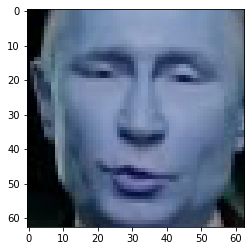

In [23]:
plt.imshow(croped_face)

In [24]:
convert_face = np.expand_dims(cv2.resize(croped_face[int(0.10 * croped_face.shape[0]): int(- 0.10 * croped_face.shape[0]), int(0.10 * croped_face.shape[1]): int(- 0.10 * croped_face.shape[1])], (64,64)).transpose((2,0,1)), axis=0) / 255

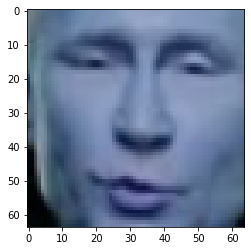

In [25]:
plt.imshow(np.squeeze(convert_face).transpose(1,2,0))

In [26]:
result = model(torch.tensor(convert_face).to(device).float(), 'B')

In [27]:
T = transforms.Compose(([
    transforms.ToPILImage(),
    transforms.Resize((155, 155)),
    transforms.ToTensor()
]))

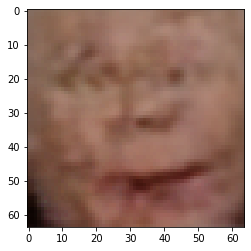

In [28]:
plt.imshow(np.squeeze(result.detach().cpu().numpy()).transpose((1,2,0)))

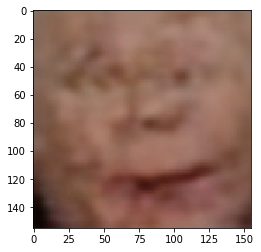

In [29]:
plt.imshow(np.squeeze(T(result.squeeze().cpu()).numpy()).transpose((1,2,0)))

In [98]:
!ffmpeg -i video/low_putin.avi -ss 00:00:45 -to 00:02:20 -async 1 -c copy video/short_low_putin.avi

ffmpeg version 3.4.6-0ubuntu0.18.04.1 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.3.0-16ubuntu3)
  configuration: --prefix=/usr --extra-version=0ubuntu0.18.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --ena

In [74]:
%%time
process_video('video/low_putin_2018.mp4', 'video/processed5.avi', 2000, 100)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
CPU times: user 2min 40s, sys: 18.9 s, total: 2min 59s
Wall time: 1min 20s


In [41]:
!ffmpeg -i video/processed4.avi -ss 00:00:02 -to 00:00:05 -async 1 -c copy video/short_processed4.avi

ffmpeg version 3.4.6-0ubuntu0.18.04.1 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.3.0-16ubuntu3)
  configuration: --prefix=/usr --extra-version=0ubuntu0.18.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --ena

In [42]:
!ffmpeg -i video/processed5.avi -f gif video/putin2018_to_putin2019.gif

ffmpeg version 3.4.6-0ubuntu0.18.04.1 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.3.0-16ubuntu3)
  configuration: --prefix=/usr --extra-version=0ubuntu0.18.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --ena